<a href="https://colab.research.google.com/github/Eddythemachine/classification_coursera/blob/main/BaggingClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT LIBS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create Sample Data

In [ ]:
# Create Sample Data
import random

# Number of samples
n_samples = 20000

# Generate synthetic data
data = {
    'age': np.random.randint(18, 70, n_samples),
    'income': np.random.randint(30000, 120000, n_samples),
    'education': [random.choice(['High School', 'Bachelors', 'Masters', 'PhD']) for _ in range(n_samples)],
    'marital_status': [random.choice(['Single', 'Married', 'Divorced']) for _ in range(n_samples)],
    'children': np.random.randint(0, 4, n_samples),
    'purchase': np.random.randint(0, 2, n_samples) # Binary target variable (0 or 1)
}

df = pd.DataFrame(data)

print(f"Generated a DataFrame with {n_samples} samples and {len(df.columns)} features.")
display(df.head())

Generated a DataFrame with 20000 samples and 6 features.


,age,income,education,marital_status,children,purchase
0,41,85870,Bachelors,Single,1,0
1,27,40794,High School,Married,0,0
2,67,68203,Bachelors,Divorced,0,0
3,54,55345,Masters,Married,0,1
4,23,45429,PhD,Married,3,1


#EDA

In [ ]:
df.isnull().sum()

,0
age,0
income,0
education,0
marital_status,0
children,0
purchase,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
cat_col = df.select_dtypes(exclude=np.number).columns.tolist()
target_col = 'purchase'

if target_col in num_col:
    num_col.remove(target_col)

print("Numerical columns:", num_col)
print("Categorical columns:", cat_col)

Numerical columns: ['age', 'income', 'children']
Categorical columns: ['education', 'marital_status']


## Plot Histograms for Numerical Columns

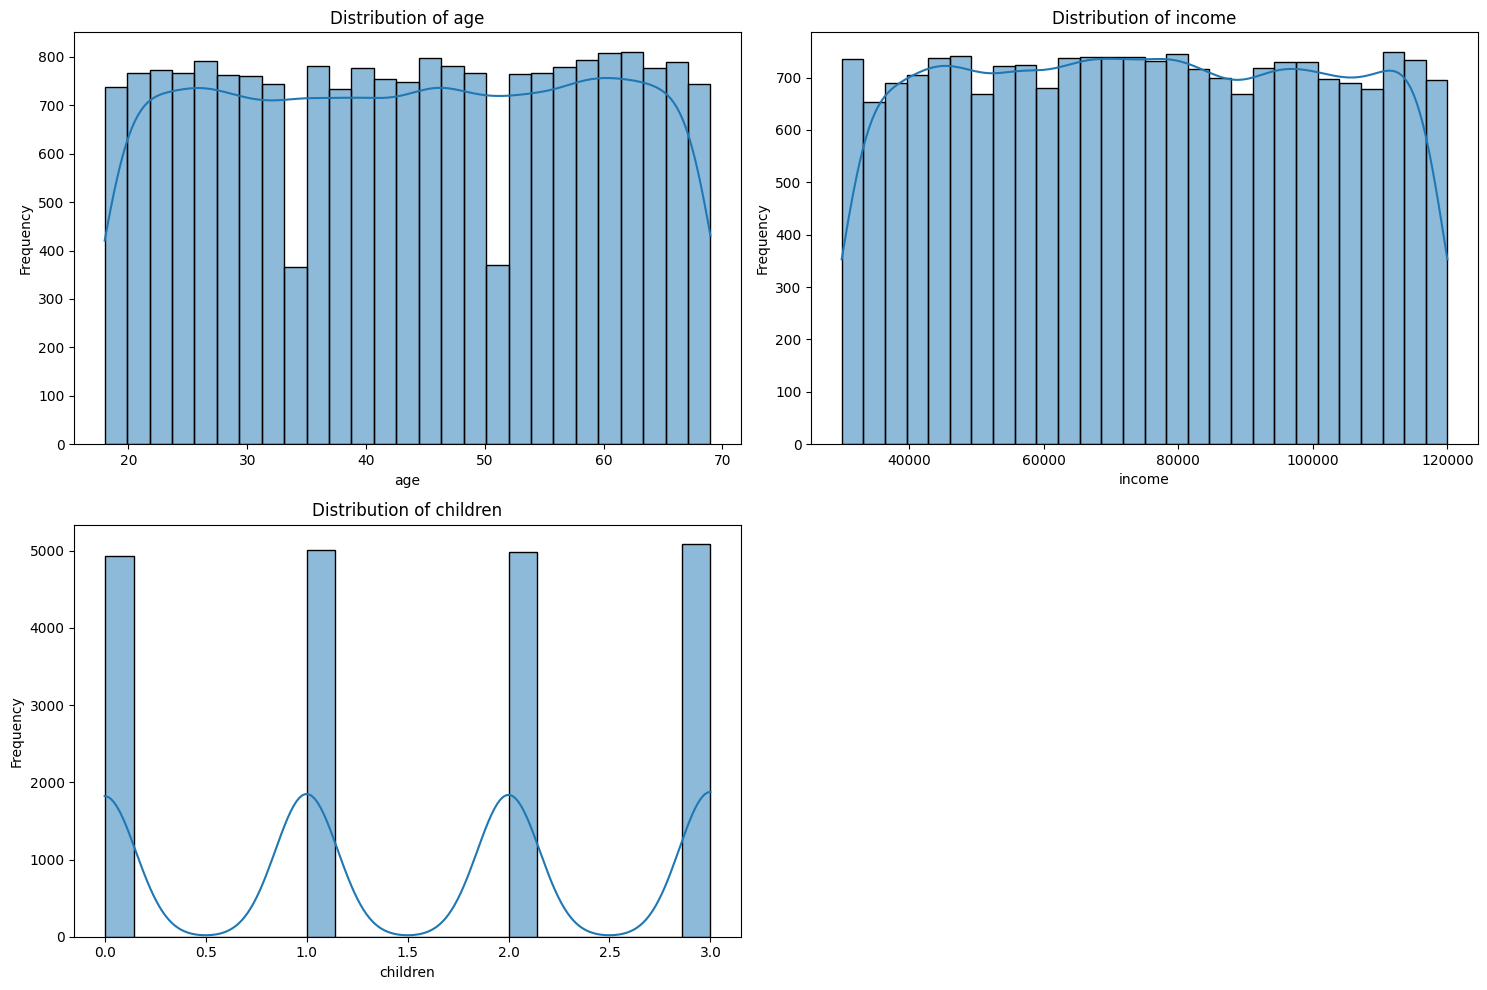

In [ ]:
# Histogram
def plot_numerical_histograms(df, numerical_cols):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols):
        plt.subplot(len(numerical_cols) // 2 + 1, 2, i + 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_numerical_histograms(df, num_col)

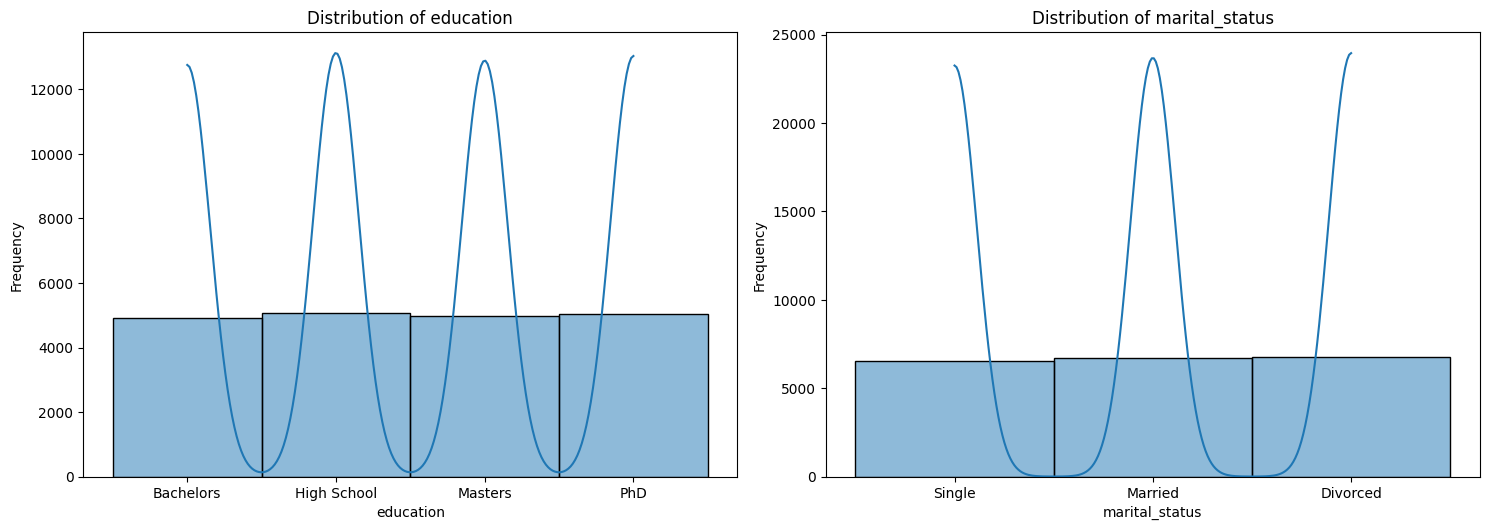

In [ ]:
plot_numerical_histograms(df, cat_col)

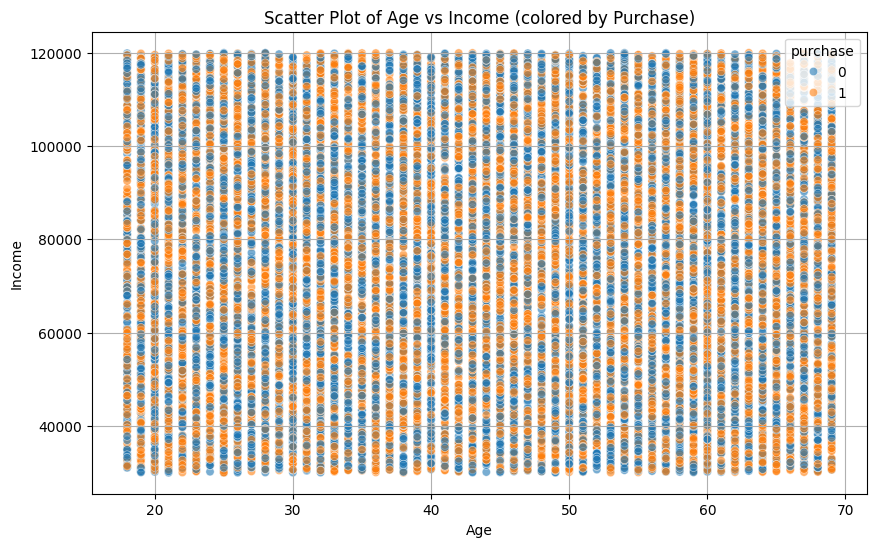

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='income', hue='purchase', alpha=0.6)
plt.title('Scatter Plot of Age vs Income (colored by Purchase)')
plt.xlabel('Age')
plt.ylabel('Income')
plt.grid(True)
plt.show()

/tmp/ipython-input-1628799249.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette='viridis')


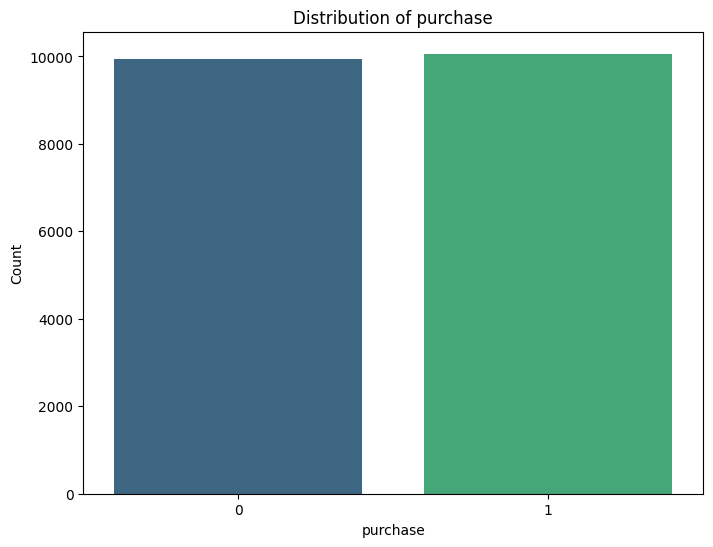

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=target_col, data=df, palette='viridis')
plt.title(f'Distribution of {target_col}')
plt.xlabel(target_col)
plt.ylabel('Count')
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
onc = OneHotEncoder(sparse_output=False, drop='first')
std = StandardScaler()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onc, cat_col),
        ('standard', std, num_col)
    ]
)

In [ ]:
DCT = DecisionTreeClassifier()

In [ ]:
Bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    random_state=42
)

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Bag)])

In [ ]:
param_grid = {
    # Bagging-level params
    'model__n_estimators': [20, 50, 100],
    'model__max_samples': [0.5, 0.7, 1.0],
    'model__max_features': [0.5, 1.0],

    # Decision Tree params inside Bagging
    'model__estimator__max_depth': [3, 5, 10,100,500],
    'model__estimator__min_samples_split': [2, 5, 10,20,50]
}


In [ ]:
X = df.drop(target_col, axis=1)
y = df[target_col]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['education',
                                                                          'marital_status']),
                                                                        ('standard',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'income',
                                                                          'children'])])),
                                       ('model',
                                        BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'model__estimator__max_depth': [3, 5, 10, 100, 500],
                         'model__estimator__min_samples_split': [2, 5, 10, 20,
                                                                 50],
                         'model__max_features': [0.5, 1.0],
                         'model__max_samples': [0.5, 0.7, 1.0],
                         'model__n_estimators': [20, 50, 100]},
             scoring='accuracy')

In [ ]:
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
best_model = grid.best_estimator_

Best Parameters: {'model__estimator__max_depth': 100, 'model__estimator__min_samples_split': 50, 'model__max_features': 1.0, 'model__max_samples': 1.0, 'model__n_estimators': 50}
Best CV Score: 0.514125


In [ ]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)


Accuracy: 0.49925


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[ 945 1032]
 [ 971 1052]]
